<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Classification-based Rating Mode Prediction using Embedding Features**


Estimated time needed: **60** minutes


In this lab, you have built regression models to predict numerical course ratings using the embedding feature vectors extracted from neural networks. We can also consider the prediction problem as a classification problem also using embedding features.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/rating_classification.png)


The workflow is very similar to our previous lab. We first extract two embedding matrices out of the neural network, and aggregate them to be a single interaction feature vector as input data `X`.

This time, with the interaction label `Y` as categorical rating mode, we can build classification models to approximate the mapping from `X` to `Y`, as shown in the above flowchart.


## Objectives


After completing this lab you will be able to:


* Build classification models to predict rating modes using the combined embedding vectors


----


## Prepare and setup lab environment


First install and import required libraries:


In [1]:
%pip install scikit-learn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# also set a random state
rs = 123

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Load datasets


In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

The first dataset is the rating dataset contains user-item interaction matrix


In [5]:
rating_df = pd.read_csv(rating_url)

In [6]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


As you can see from the above data, the user and item are just ids, let's substitute them with their embedding vectors


In [7]:
user_emb = pd.read_csv(user_emb_url)
item_emb = pd.read_csv(item_emb_url)

In [8]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


In [9]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [10]:
# Merge user embedding features
merged_df = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(merged_df, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [11]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,5,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,5,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,5,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


Each user's embedding features and each item's embedding features are added to the dataset. Next, we perform element-wise add the user features (the column labels starting with `UFeature`) and item features (the column labels starting with `CFeature`).


In [12]:
u_feautres = [f"UFeature{i}" for i in range(16)] # Assuming there are 16 user embedding features
c_features = [f"CFeature{i}" for i in range(16)] # Assuming there are 16 course embedding features
# Extract user embedding features
user_embeddings = merged_df[u_feautres]
# Extract course embedding features
course_embeddings = merged_df[c_features]
# Extract ratings
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
interaction_dataset = user_embeddings + course_embeddings.values
# Rename the columns of the resulting DataFrame
interaction_dataset.columns = [f"Feature{i}" for i in range(16)]
# Add the 'rating' column from the original DataFrame to the regression dataset
interaction_dataset['rating'] = ratings
# Display the first few rows of the regression dataset
interaction_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,5
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,5
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,5
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3


Next, let's use `LabelEncoder()` to encode our `rating` label to be categorical:


In [13]:
# Extract features (X) from the interaction_dataset DataFrame
# Selects all rows and all columns except the last column (features)
X = interaction_dataset.iloc[:, :-1]
# Extract the target variable (y_raw) from the interaction_dataset DataFrame
# Selects all rows and only the last column (target variable)
y_raw = interaction_dataset.iloc[:, -1]
# Initialize a LabelEncoder object to encode the target variable
label_encoder = LabelEncoder()
# Encode the target variable (y_raw) using the LabelEncoder
# .values.ravel() converts the target variable to a flattened array before encoding
# The LabelEncoder fits and transforms the target variable, assigning encoded labels to y
y = label_encoder.fit_transform(y_raw.values.ravel())

and split X and y into training and testing dataset:


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

In [15]:
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


## TASK: Perform classification tasks on the interaction dataset


Now our input data `X` and output label `y` is ready, let's build classification models to map `X` to `y`


You may use `sklearn` to train and evaluate various regression models.


_TODO: Define classification models such as Logistic Regression, Tree models, SVM, Bagging, and Boosting models_


In [16]:
### WRITE YOUR CODE HERE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt

# Define models and their names
models = [
    LogisticRegression(random_state=rs, max_iter=1000),
    DecisionTreeClassifier(random_state=rs),
    BaggingClassifier(estimator= LogisticRegression(random_state=rs, max_iter=1000), random_state=rs),
    # GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=rs)
]

names = [
    "Logistic Regression",
    "Decision Tree Classifier",
    "Bagging Classifier (LogisticRegression)",
    # "Gradient Boosting Classifier"
]

<details>
    <summary>Click here for Hints </summary>
    
For Example: you can call `RandomForestClassifier()` to define your model, don't forget to specify `max_depth= ..`  and `random_state=rs` in the parameters.


_TODO: Train your classification models with training data_


In [17]:
### WRITE YOUR CODE HERE
### You may need to tune the hyperparameters of the models
metrics_dict = {
    "Model": names,
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC": []
}

# Train models and compute metrics
for model, name in zip(models, names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate predicted probabilities for AUC
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = model.score(X_test, y_test)
    precision, recall, f_score, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", pos_label=1
    )
    
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') if y_pred_proba is not None else None

    # Append metrics to the dictionary
    metrics_dict["Accuracy"].append(accuracy)
    metrics_dict["Precision"].append(precision)
    metrics_dict["Recall"].append(recall)
    metrics_dict["F1-Score"].append(f_score)
    metrics_dict["AUC"].append(auc)

    # Print model performance
    print(f"{name} -> Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1-Score: {f_score:.4f}, AUC: {auc:.4f}")

Logistic Regression -> Accuracy: 0.3347, Precision: 0.3354, Recall: 0.3347, F1-Score: 0.3265, AUC: 0.5000
Decision Tree Classifier -> Accuracy: 0.3356, Precision: 0.3357, Recall: 0.3356, F1-Score: 0.3357, AUC: 0.5017
Bagging Classifier (LogisticRegression) -> Accuracy: 0.3348, Precision: 0.3353, Recall: 0.3348, F1-Score: 0.3312, AUC: 0.4999


<details>
    <summary>Click here for Hints</summary>
    
You can call `model.fit()` method with `X_train, y_train` parameters.


_TODO: Evaluate your classification models_


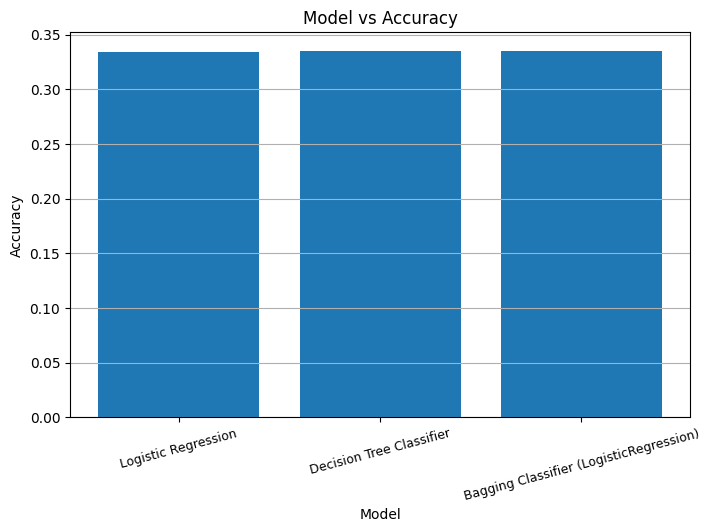

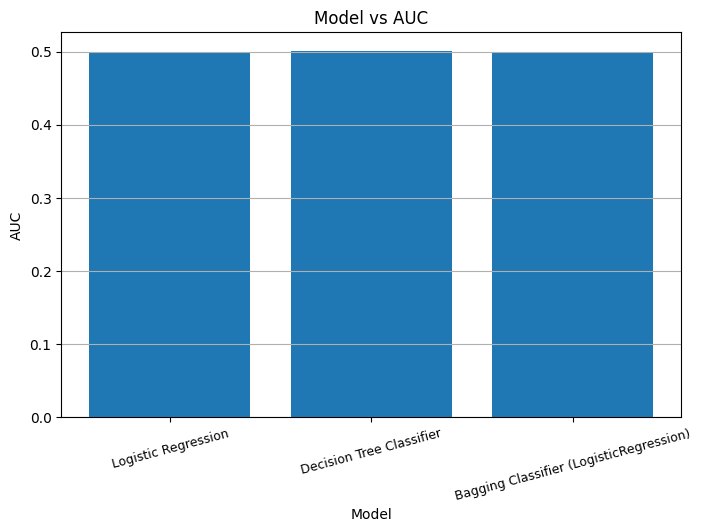

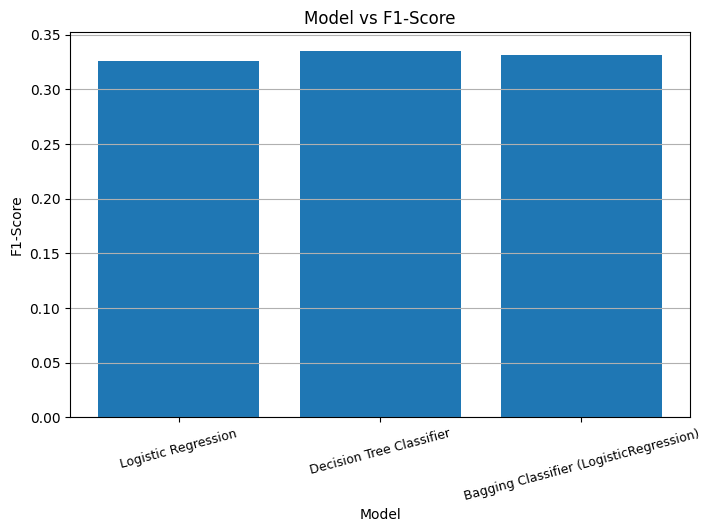

In [18]:
### WRITE YOUR CODE HERE

### The main evaluation metrics could be accuracy, recall, precision, F score, and AUC.
for metric in ["Accuracy", "AUC", "F1-Score"]:
    plt.figure(figsize=(8, 5))
    plt.bar(names, metrics_dict[metric])
    plt.title(f"Model vs {metric}")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=15, fontsize=9)
    plt.grid(True, axis="y") 
    plt.show()

<details>
    <summary>Click here for Hints</summary>
    
You can call `model.predict()` method with `X_test` parameter to get model predictions. Then use `accuracy_score()` with `y_test, your_predictions` parameters to calculate the accuracy value. 
* You can use `precision_recall_fscore_support` command  with `y_test, your_predictions, average='binary'` parameters get recall, precision and F score.
    


### Summary


In this lab, you have built and evaluated various classification models to predict categorical course rating modes using the embedding feature vectors extracted from neural networks.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


```toggle## Change Log
```


```toggle|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
```
```toggle|-|-|-|-|
```
```toggle|2021-10-25|1.0|Yan|Created the initial version|
```


Copyright © 2021 IBM Corporation. All rights reserved.
